In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io
import numpy as np

In [99]:
#Hyperparameter
patch_size=21
h=.01 #std of the noise
dt=0.1 #Learning rate
lamda=0.1 #Lagrange multiplier
mat = scipy.io.loadmat('H.mat')
K=cv2.resize(cv2.imread('K.jpg',0),(200,100))
K_adj=K.conjugate()
uo=cv2.imread('uo.jpg',0)
f=cv2.resize(cv2.imread('f.jpg',0),(200,100))
uosize=cv2.resize(uo,(200,100))
H,W=uosize.shape
HP,WP=H+patch_size-1,W+patch_size-1

In [101]:
#paded_image
uopad=np.pad(uosize, (patch_size//2, patch_size//2), 'edge')
#Create Patch for all pixels
Patch=create_Patch(H,W,patch_size,uopad)
#Create gaussian kernel
g=create_gaussian_kernel(patch_size,sigma=1,muu=0)
#Create Weight Function
w=create_weight_matrix(H,W,patch_size,Patch,g,h)

<ipython-input-6-d5fffe3013b2>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(ww)


In [96]:
loss,uo_size=training_restoration(10,0.001,H,W,patch_size,Patch,w,uosize,K,K_adj,f,0.2)

Total_Loss: -44433.606448632956

Total_Loss: 4642434.722450934

Total_Loss: 4497819.2146777585

Total_Loss: 4353938.526161769

Total_Loss: 4210810.4742901

Total_Loss: 4068460.198942802

Total_Loss: 3926923.4274652204

Total_Loss: 3786252.0875939527

Total_Loss: 3646524.871440526

Total_Loss: 3507869.9102784107



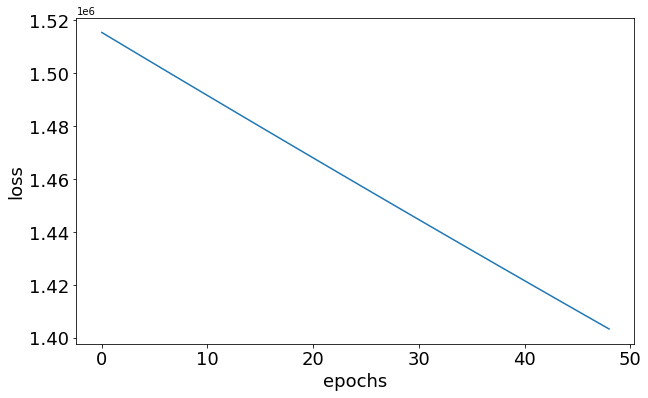

In [73]:
plt.figure(figsize=(10,6))
plt.plot(loss[1:])
plt.xlabel('epochs',fontsize=18)
plt.ylabel('loss',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('Loss_curve.jpg',dpi=300)

In [98]:
cv2.imwrite('recons_img_0.01.jpg',uo_size)

True

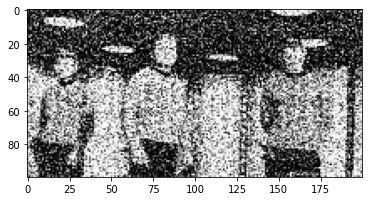

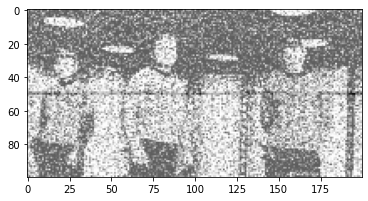

In [97]:
plt.figure(1)
plt.imshow(uosize,cmap='gray')
plt.figure(2)
plt.imshow(uo_size,cmap='gray')

In [100]:
def create_Patch(H,W,patch_size,uopad):
    Patch=np.zeros((H,W,patch_size,patch_size));
    for i in range(H):
        for j in range(W):
            Patch[i,j,:,:]=uopad[i:i+patch_size,j:j+patch_size]
    return Patch

In [5]:
def training_restoration(epochs,dt,H,W,patch_size,Patch,w,uosize,K,K_adj,f,lamda):
    uo=uosize.copy()
    L=[];
    for i in range(epochs):
        #Create nonlocal_minimum_loss
        l1=nonlocal_minimum_loss(H,W,patch_size,Patch,w)
        #Create restration_loss
        l2=restoration_loss(uo,K,K_adj,f,lamda)

        #Total loss
        loss=l1+l2
        
        L.append(np.sum(loss))
        
        print(f"Total_Loss: {np.sum(loss)}\n")

        #Update uosize
        uo=uo-dt*loss
        
        #Normalize uo
        uo=(uo/np.max(uo))*255
        
        #Padding
        uopad=np.pad(uo, (patch_size//2, patch_size//2), 'edge')
        #Patch
        Patch=create_Patch(H,W,patch_size,uopad)
    
    return L,uo

In [6]:
def create_weight_matrix(H,W,patch_size,Patch,g,h):
    ww=[];
    for i in range(H):
        w=[];
        for j in range(W):
            r1,r2,c1,c2=np.array([0]),np.array([patch_size]),np.array([0]),np.array([patch_size])
            rs,re,cs,ce=max(0,i-patch_size//2),min(H,i+patch_size//2+1),max(0,j-patch_size//2),min(W,j+patch_size//2+1)
            r1[rs==0],r2[re==H],c1[cs==0],c2[ce==W]=21-(re-rs),re-rs,21-(ce-cs),ce-cs
            PX=Patch[i,j,int(r1):int(r2),int(c1):int(c2)]
            PY=Patch[rs:re,cs:ce,:,:]
            w.append(np.array(weight_matrix(i,j,PX,PY,rs,re,cs,ce,g,h)))
        ww.append(w)
    return np.array(ww)    

In [7]:
def nonlocal_minimum_loss(H,W,patch_size,Patch,w):
    LU=[];
    for i in range(H):
        LU1=[];
        for j in range(W):
            r1,r2,c1,c2=np.array([0]),np.array([patch_size]),np.array([0]),np.array([patch_size])
            rs,re,cs,ce=max(0,i-patch_size//2),min(H,i+patch_size//2+1),max(0,j-patch_size//2),min(W,j+patch_size//2+1)
            r1[rs==0],r2[re==H],c1[cs==0],c2[ce==W]=21-(re-rs),re-rs,21-(ce-cs),ce-cs
            PX=Patch[i,j,int(r1):int(r2),int(c1):int(c2)]
            Lu=-np.sum((PX-PX[patch_size//2,patch_size//2])*w[i,j])/np.sum(w[i,j])
            LU1.append(Lu)
        LU.append(LU1)
    return np.array(LU)    

In [8]:
"""
https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
"""
def create_gaussian_kernel(patch_size,sigma=1,muu=0):
    x, y = np.meshgrid(np.linspace(-1,1,patch_size), np.linspace(-1,1,patch_size))
    dst = np.sqrt(x*x+y*y)
    gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
    return gauss

In [10]:
def weight_calculation(patch1,patch2,g,h=1):
    return np.sum(np.exp(-g*(patch1-patch2)**2/h**2))

In [14]:
def restoration_loss(u,K,K_adj,f,lamda):
    w_f=K_adj*(K*u-f)
    w=lamda*np.fft.ifft(w_f)
    return abs(w)

In [15]:
def weight_matrix(i,j,PX,PY,rs,re,cs,ce,g,h):
    PX=np.squeeze(Patch[i,j,:,:])
    pr,pc,_,_=PY.shape
    w=[];
    for m in range(pr):
        for n in range(pc):
            w.append(weight_calculation(PX,PY[m,n,:,:],g,h=1))
    return np.array(w).reshape(pr,pc)        